In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

# Load experimental subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Test one session

In [6]:
choose_sub = 1
exprow = all_subexp.iloc[choose_sub]
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


## Load experimental data

### Load stim log

In [9]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [10]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,2961.90928,2961.90968,0,0.000000,True,False,True
1,biphasic,50,0.0004,2982.91487,2982.91527,0,0.000000,True,True,True
2,biphasic,50,0.0004,3001.93576,3001.93616,0,0.607456,False,False,True
3,biphasic,50,0.0004,3021.96011,3021.96051,0,0.303728,False,True,True
4,biphasic,50,0.0004,3042.75694,3042.75734,0,0.000000,True,False,True


### Load manual annotation of event in SWD

In [11]:
stimSWDfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP.npy')
if os.path.exists(stimSWDfile):
    stim_in_SWD = np.load(stimSWDfile)
    print(stim_in_SWD[:10])
    stim_log['manualSWD'] = stim_in_SWD
else:
    print('Session has no EP_in_SWD file.')

['t' 't' 'f' 'f' 'a' 'f' 'a' 'f' 'a' 'a']


### Load SWD events

In [12]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


In [13]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,30.672867,32.045674,1.372807,10,"[30.67286684096313, 30.913668085150377, 31.054..."
1,34.457286,36.512097,2.054811,14,"[34.457286394543786, 34.58928707657334, 34.725..."
2,37.027700,39.314111,2.286412,14,"[37.02769967551929, 37.202100576625014, 37.513..."
3,40.722119,42.564528,1.842410,9,"[40.722118764079795, 40.86451949984502, 41.181..."
4,44.878540,47.866956,2.988415,18,"[44.87854023974374, 45.03494104784542, 45.1637..."


### Load pupil radius

### Load running speed

### Load EEG to use the timestamps

In [14]:
eegts = np.load(exp.ephys_params['EEG']['timestamps'])

### Load isoflurane signal

## Load LFP

### Get probe list

In [15]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [16]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeB
['CA1' 'CA2' 'CA3' 'DG-mo' 'LD' 'PO' 'SSp-tr1' 'SSp-tr2/3' 'SSp-tr4'
 'SSp-tr5' 'SSp-tr6a' 'SSp-tr6b' 'alv' 'ccb' 'cing' 'null' 'root']

probeC
['CA1' 'CA2' 'CA3' 'SSp-tr5' 'SSp-tr6a' 'SSp-tr6b' 'VISa1' 'VISa2/3'
 'VISa4' 'VISa5' 'VL' 'alv' 'ccb' 'fi' 'null' 'scwm']

probeF
['BST' 'CP' 'LSv' 'MOp1' 'MOp2/3' 'MOp5' 'MOp6a' 'MOp6b' 'VL' 'ccg' 'null'
 'scwm']



### Choose probe to plot

In [17]:
probe_name = 'probeB'

## Load LFP as memmap ##
# lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
# lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
#     (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [18]:
print(surface_ch)

368


In [19]:
area_chs = np.nonzero(probe_areas == 'SSp-tr6b')[0]
print(area_chs)

[252 253 254 255]


#### Load a single channel

In [20]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [50]:
plot_ch = 45
lfp_ch = lfp_data_mm[:, plot_ch] * exp.ephys_params[probe_name]['bit_volts']
## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
# hardware_filter = signal.butter(1, Wn=[0.5, 50], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
# lfp_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_ch)))

In [22]:
print(probe_areas[plot_ch])

SSp-tr5


Plot filtered signal

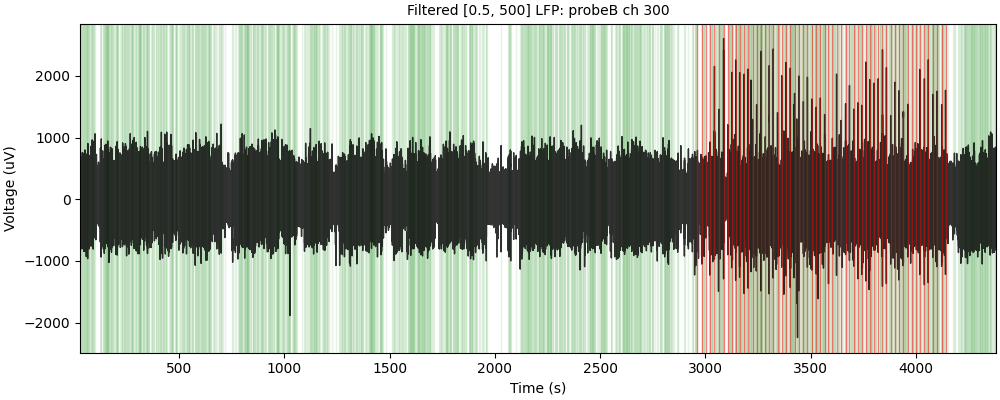

In [29]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfp_ts, lfp_ch, color='k', linewidth=1.0, alpha=0.8)
## Add stim events ##
# for ii, stimi in stim_log.iterrows():
#     ax.axvspan(stimi.onset, stimi.offset, color='r', alpha=0.1)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Filtered [0.5, 500] LFP: {} ch {:d}'.format(probe_name, plot_ch))

## Add SWD events ##
if autoSWD_df is not None:
    for ii, SWDi in autoSWD_df.iterrows():
        ax.axvspan(SWDi.onset, SWDi.offset, color='g', alpha=0.1)

## Add stim events ##
if stim_log is not None:
    for stype in np.unique(stim_log.stim_type.values):
        if stype == 'circle':
            evcol = 'c'
            evlabel = 'visual stim'
        elif stype == 'biphasic':
            evcol = 'r'
            evlabel = 'elec stim'
        stypeevents = stim_log[stim_log['stim_type'] == stype].onset.values
        for eventi_on in stypeevents:
            ax.axvline(eventi_on, color=evcol, linewidth=1.0, alpha=0.5)
        # legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc=evcol, alpha=0.5, label=evlabel))

# ## Running ##
# runax = ax.twinx()
# run, = runax.plot(speedts, speed, color='m', alpha=0.6, label='speed')
# # legenditems.append(run)
# runax.set_ylabel('Speed (cm/s)', color='m')
# runax.tick_params(axis='y', colors='m')
# runax.set_ylim([-1, 30])

# ## Pupil ##
# if pupilR is not None:
#     pupax = ax.twinx()
#     pupax.spines.right.set_position(("axes", 1.08))
#     pup, = pupax.plot(pupilts, pupilR, color='b', alpha=0.6, label='pupil')
#     # pup, = pupax.plot(pupilts, sm_pupil, color='b', alpha=0.6, label='pupil')
#     # legenditems.append(pup)
#     pupax.set_ylim([-2, 120])
#     pupax.set_ylabel('Pupil radius (pixels)', color='b')
#     pupax.tick_params(axis='y', colors='b')

### Epoch data to plot EP

In [51]:
event_window = [-2.0, 2.0]

In [52]:
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']

In [53]:
plot_events.tail()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good,manualSWD
55,biphasic,50,0.0004,4058.90299,4058.90339,0,0.0,True,True,True,a
56,biphasic,50,0.0004,4080.20677,4080.20718,0,0.0,True,False,True,f
57,biphasic,50,0.0004,4100.36068,4100.36108,0,0.0,True,True,True,f
58,biphasic,50,0.0004,4122.34575,4122.34615,0,0.0,True,False,True,t
59,biphasic,50,0.0004,4140.65896,4140.65936,0,0.0,True,False,True,a


In [54]:
print(len(plot_events.manualSWD.values))
print(np.sum(plot_events.manualSWD.values))

60
ttffafafaaaaatfafaafaaafataffffffaftttffaataaafffffffaaaffta


In [55]:
event_LFPch, event_ts = get_evoked_traces(
    lfp_ch[:, None], lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate'])
event_LFPch = np.squeeze(event_LFPch)

Text(0.5, 1.0, 'All stim trials')

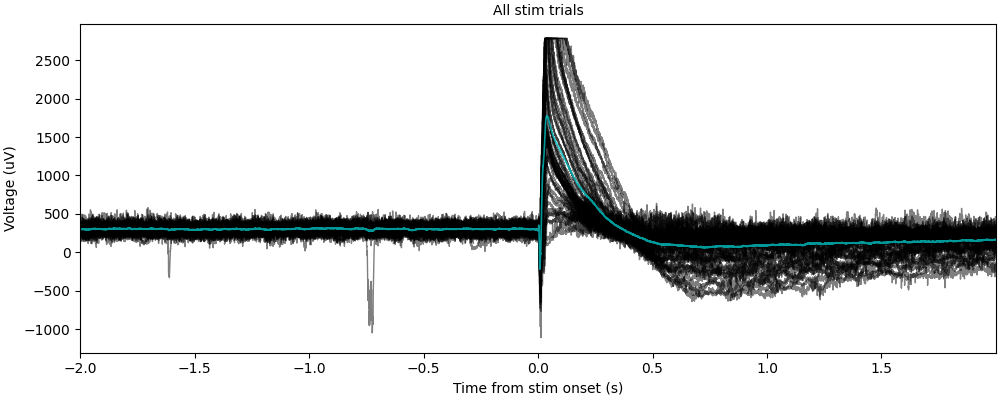

In [56]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPch, color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPch, axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('All stim trials')

Text(0.5, 1.0, 'Plot "a" trials (25)')

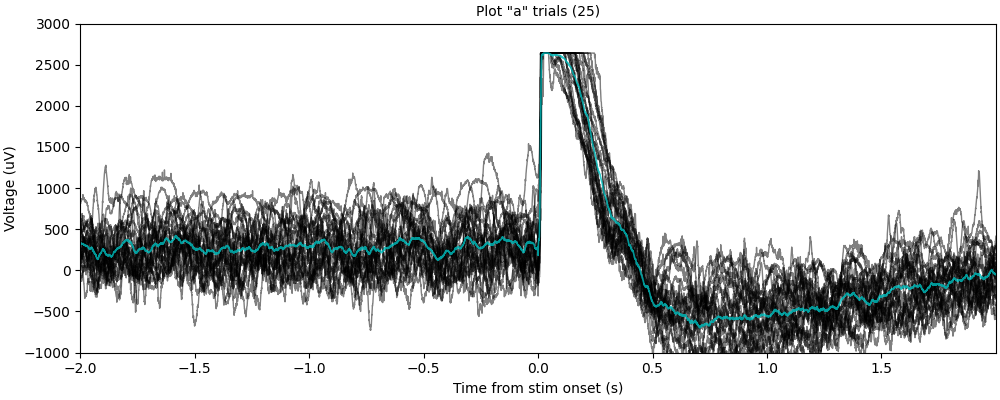

In [29]:
plot_trials = 'a' # choose t, f, or a
stimtype = 'biphasic'
eventinds = get_events_wdict(stim_log, {'stim_type': stimtype, 'manualSWD': plot_trials}, out='index')

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPch[:,eventinds], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPch[:,eventinds], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_ylim([-1000, 3000])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Plot "{}" trials ({:d})'.format(plot_trials, len(eventinds)))

In [47]:
np.max(event_LFPch)

2683.7850000000003

Text(0.5, 1.0, 'Plot trials that reach max value (20)')

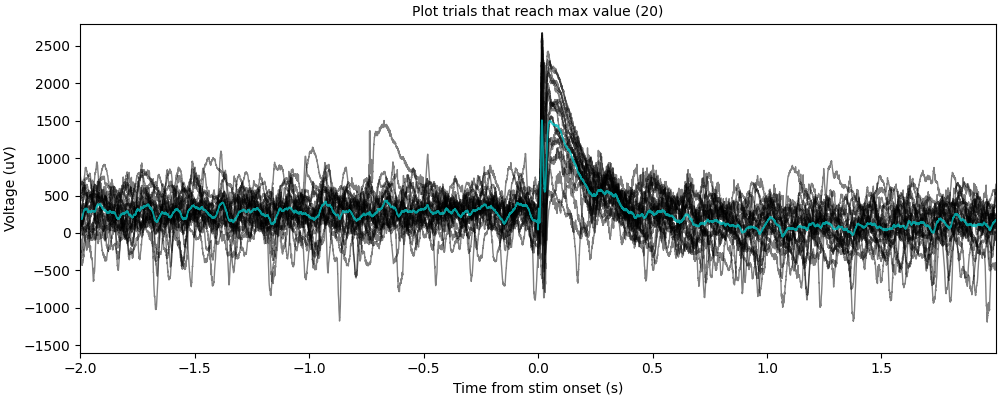

In [49]:
check_window = [-0.05, 0.5]
checkinds = np.squeeze(np.argwhere((event_ts >= check_window[0]) & (event_ts <= check_window[1])))
artifact_mask = np.sum(event_LFPch[checkinds, :] > 2660, axis=0) < 10

fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPch[:,artifact_mask], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPch[:,artifact_mask], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_ylim([-1600, 2800])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Plot trials that reach max value ({:d})'.format(np.sum(artifact_mask)))

Plot in vs. out

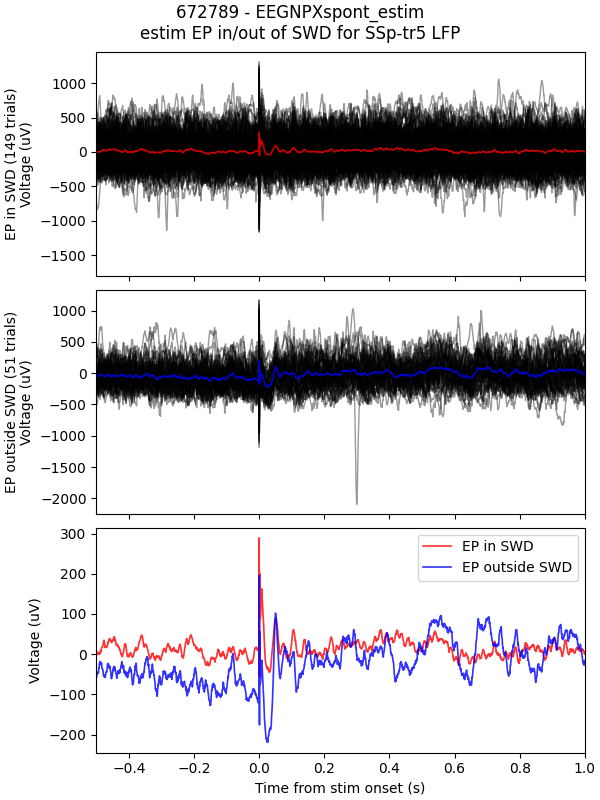

In [60]:
stimtype = 'biphasic'
ppcomp = {True: 'red', False: 'blue'}
pwin = [-0.5, 1.0]
fig, axs = plt.subplots(3, 1, figsize=(6, 8), constrained_layout=True, sharex=True)

in_out_EP = []
for ii, (SWDi, pcol) in enumerate(ppcomp.items()):
    event_times = get_events_wdict(stim_log, {'stim_type': stimtype, 'manualSWD': SWDi}, out='onset')
    event_LFPch, event_ts = get_evoked_traces(
        lfp_ch[:, None], lfp_ts, event_times, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate'])
    event_LFPch = np.squeeze(event_LFPch)
    if SWDi:
        ylab = 'EP in SWD ({:d} trials)'.format(np.shape(event_LFPch)[1])
    else:
        ylab = 'EP outside SWD ({:d} trials)'.format(np.shape(event_LFPch)[1])

    axs[ii].plot(event_ts, event_LFPch, color='k', linewidth=1.0, alpha=0.4)
    axs[ii].plot(event_ts, np.mean(event_LFPch, axis=1), color=pcol, linewidth=1.2, alpha=0.8)
    axs[ii].set_ylabel(ylab + '\nVoltage (uV)')
    in_out_EP.append(np.mean(event_LFPch, axis=1))

for ii, (SWDi, pcol) in enumerate(ppcomp.items()):
    if SWDi:
        ll = 'EP in SWD'
    else:
        ll = 'EP outside SWD'
    axs[2].plot(event_ts, in_out_EP[ii], color=pcol, linewidth=1.2, alpha=0.8, label=ll)
axs[2].set_xlim(pwin)
axs[2].legend()
axs[2].set_xlabel('Time from stim onset (s)')
axs[2].set_ylabel('Voltage (uV)')

plt.suptitle('{} - {}\nestim EP in/out of SWD for {} LFP'.format(exp.mouse, exp_tag, probe_areas[plot_ch]))

### SAVE ###
fig_name = '{}_LFP_EP_inoutSWD.png'.format(probe_areas[plot_ch])
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Test the filter
<br>The filter doesn't alter the signal or the SWDs in a negative way. Looks good.

In [26]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [27]:
plot_ch = 280
lfpraw_ch = lfp_data_mm[:, plot_ch] * exp.ephys_params[probe_name]['bit_volts']

In [28]:
## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
# hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
hardware_filter = signal.butter(1, Wn=[2, 50], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
lfpfilt_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfpraw_ch)))

Text(0.5, 1.0, 'Raw and filtered LFP: probeD ch 280')

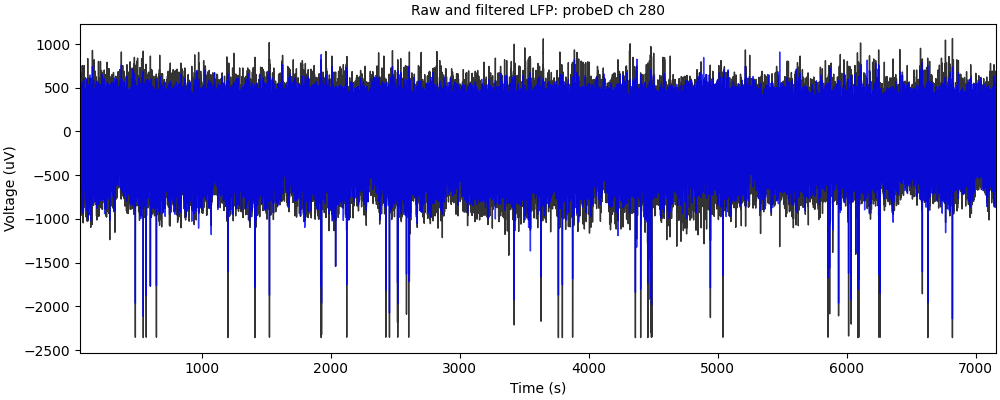

In [29]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfp_ts, lfpraw_ch, color='k', linewidth=1.0, alpha=0.8)
ax.plot(lfp_ts, lfpfilt_ch, color='b', linewidth=1.0, alpha=0.8)

ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw and filtered LFP: {} ch {:d}'.format(probe_name, plot_ch))

### Test the difference between two chs

In [21]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [22]:
plot_ch = 280
lfp_ch = lfp_data_mm[:, plot_ch] * exp.ephys_params[probe_name]['bit_volts']
lfp_sal = lfp_data_mm[:, 380] * exp.ephys_params[probe_name]['bit_volts']
## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
# hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate'])
# lfp_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_ch)))

Text(0.5, 1.0, 'Raw LFP: probeD ch 280')

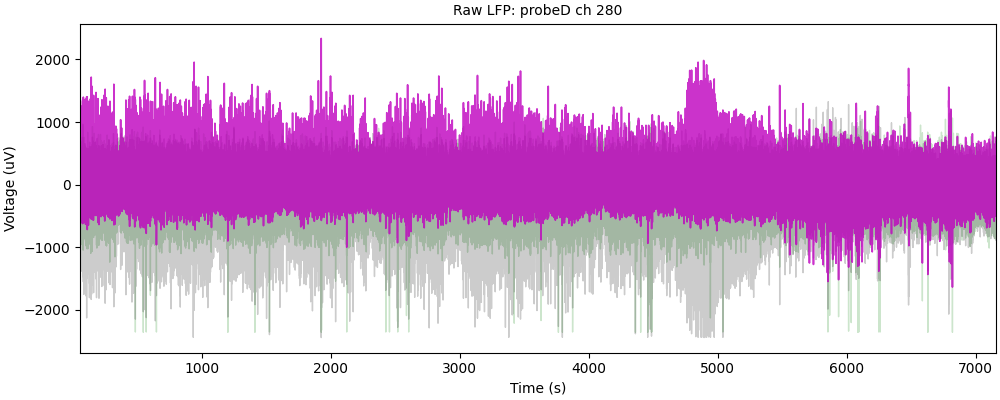

In [24]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfp_ts, lfp_ch, color='g', linewidth=1.0, alpha=0.2)
ax.plot(lfp_ts, lfp_sal, color='k', linewidth=1.0, alpha=0.2)
ax.plot(lfp_ts, lfp_ch-lfp_sal, color='m', linewidth=1.2, alpha=0.8)
## Add stim events ##
# for ii, stimi in stim_log.iterrows():
#     ax.axvspan(stimi.onset, stimi.offset, color='r', alpha=0.1)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: {} ch {:d}'.format(probe_name, plot_ch))